# Further line analysis from saved moment images

The previous notebook has grown too long, so I am starting a new one.  What I plan to do here is: 

1. [X] [Cl III] density ratio. *Conclusion:* [Cl III] is useless
2. [X] [S II] density - this is the best
2. [ ] Maybe tetrablok binning and make figure
3. [ ] Profile cuts across the bow shock
4. [ ] Analysis of average line velocities 


In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Image
import regions
import sys
import pandas as pd
import cmasher as cmr
import pyneb as pn

sns.set_context("talk")
sns.set_color_codes()

In [16]:
def trim_edges(im, m):
    """Trim m pixels of each edge of image in place by setting mask"""
    im.mask[:m, :] = True
    im.mask[-m:, :] = True
    im.mask[:, :m] = True
    im.mask[:, -m:] = True
    return None

## [S II] density

In [234]:
im6716 = Image("../data/ngc346-sii-6716-bin01-sum.fits")
im6731 = Image("../data/ngc346-sii-6731-bin01-sum.fits")
imha = Image("../data/ngc346-hi-6563-bin01-sum.fits")
imcont = Image("../data/ngc346-cont-6312-mean.fits")

In [256]:
s2 = pn.Atom("S", 2)
e6716 = s2.getEmissivity(tem=13000, den=[3, 10, 30, 100, 300, 1000], wave=6716)
e6731 = s2.getEmissivity(tem=13000, den=[3, 10, 30, 100, 300, 1000], wave=6731)
Rgrid = e6716 / e6731
Rgrid

array([1.43878982, 1.43185268, 1.4125499 , 1.35049829, 1.20992   ,
       0.93887822])

In [236]:
m = imcont.data > 5e3
im6716.mask = im6716.mask | m
im6731.mask = im6731.mask | m
trim_edges(im6716, 10)
trim_edges(im6731, 10)
trim_edges(imcont, 10)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


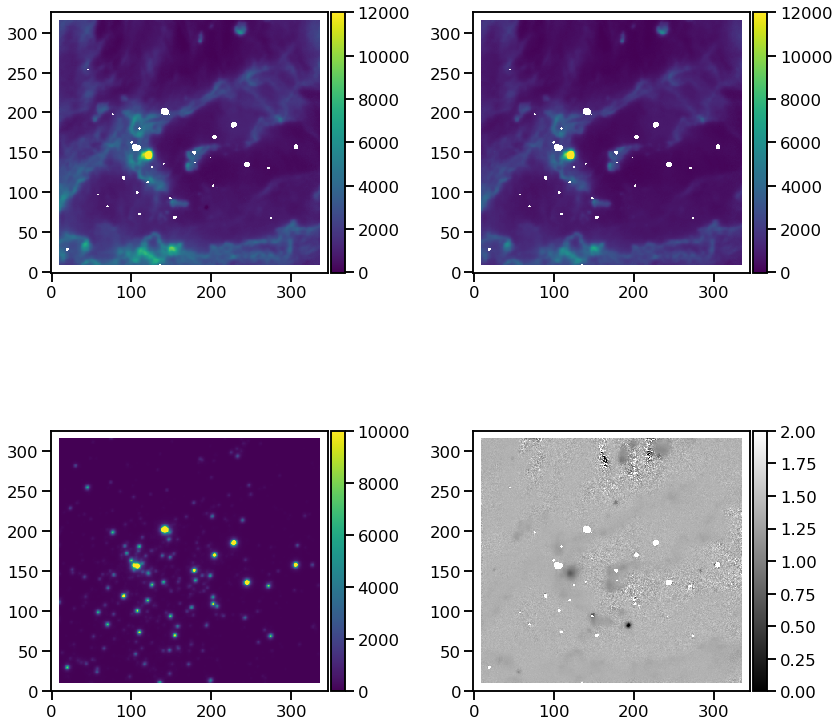

In [237]:
n = 1
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
im6716.rebin(n).plot(vmin=-10, vmax=12000, ax=axes[0, 0], colorbar="v")
im6731.rebin(n).plot(vmin=-10, vmax=12000, ax=axes[0, 1], colorbar="v")
imcont.rebin(n).plot(vmin=0, vmax=1e4, ax=axes[1, 0], colorbar="v")
(
    im6716.rebin(n)
    / im6731.rebin(n)
).plot(
    ax=axes[1, 1],
    vmin=0.0, 
    vmax=2.0, 
    cmap="gray", 
    colorbar="v",
)
fig.tight_layout();

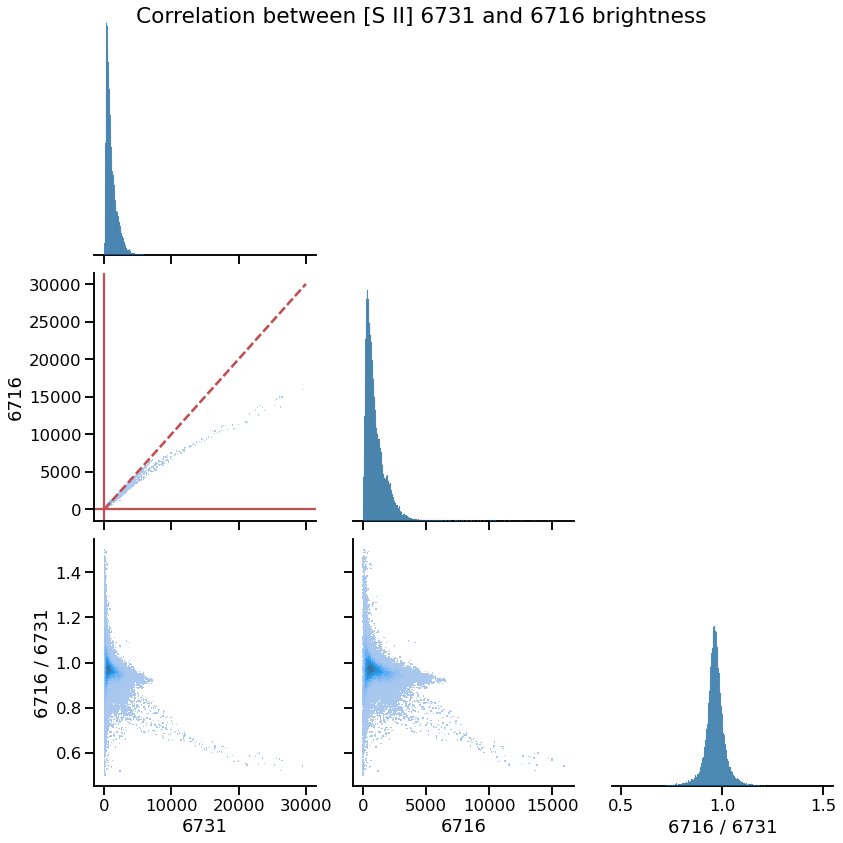

In [245]:
n = 1

imx = im6731.rebin(n)
imy = (im6716 / 1.44).rebin(n)

imin, imax = -10, 30000
m = (imx.data < imax) & (imy.data < imax)
m = m & (imx.data > imin) & (imy.data > imin)
m = m & (imy.data / imx.data > 0.5) & (imy.data / imx.data  < 1.5)
m = m & ~imx.mask & ~imy.mask
df = pd.DataFrame(
    {
        "6731": imx.data[m],
        "6716": imy.data[m],
        "6716 / 6731": imy.data[m] / imx.data[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([imin, imax], [imin, imax], "--", color="r")
g.axes[1, 0].plot([imin, imax], [imin, imax], "--", color="r")
g.fig.suptitle("Correlation between [S II] 6731 and 6716 brightness");

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


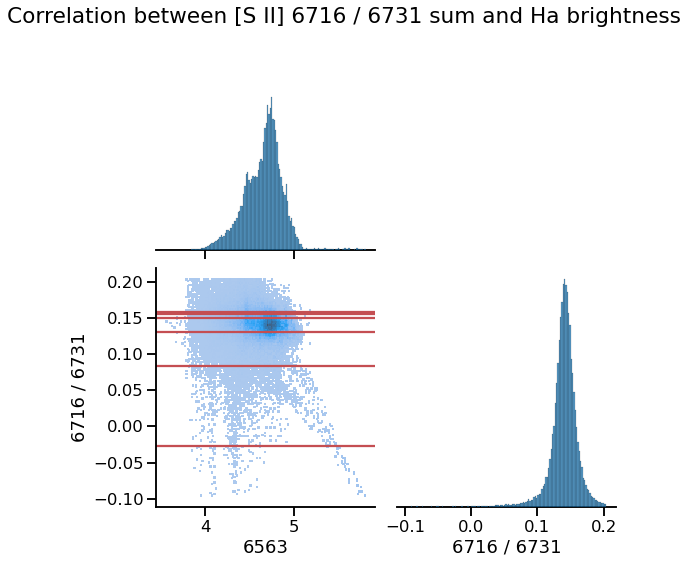

In [272]:
n = 1
imx = imha.rebin(n)
imy = im6716.rebin(n) / im6731.rebin(n)

m = (imy.data > 0.8) & (imy.data < 1.6)
m = m & (imx.data < 1.5e6)
m = m & ~imx.mask & ~imy.mask
df = pd.DataFrame(
    {
        "6563": np.log10(imx.data[m]),
        "6716 / 6731": np.log10(imy.data[m]),
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=imx.data[m],
        bins=150,
    ),
    diag_kws=dict(
        weights=imx.data[m],
        bins=150,
    ),
)
for R in Rgrid:
    g.axes[1, 0].axhline(np.log10(R), color="r")
g.fig.suptitle("Correlation between [S II] 6716 / 6731 sum and Ha brightness");

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


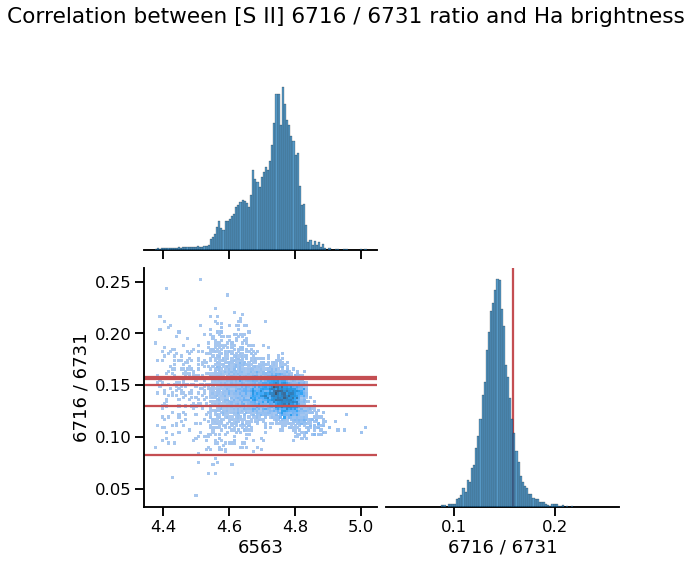

In [273]:
xslice, yslice = slice(230, 300), slice(144, 245)

n = 1

imx = imha[yslice, xslice].rebin(n)
imy = im6716[yslice, xslice].rebin(n) / im6731[yslice, xslice].rebin(n)

m = (imy.data > 1.1) & (imy.data < 2)
m = m & (imx.data < 1e6)
m = m & ~imx.mask & ~imy.mask
df = pd.DataFrame(
    {
        "6563": np.log10(imx.data[m]),
        "6716 / 6731": np.log10(imy.data[m]),
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=imx.data[m],
        bins=100,
    ),
    diag_kws=dict(
        weights=imx.data[m],
        bins=100,
    ),
)
g.axes[1, 1].axvline(np.log10(Rgrid[0]), color="r")
for R in Rgrid[:-1]:
    g.axes[1, 0].axhline(np.log10(R), color="r")

g.fig.suptitle("Correlation between [S II] 6716 / 6731 ratio and Ha brightness");

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


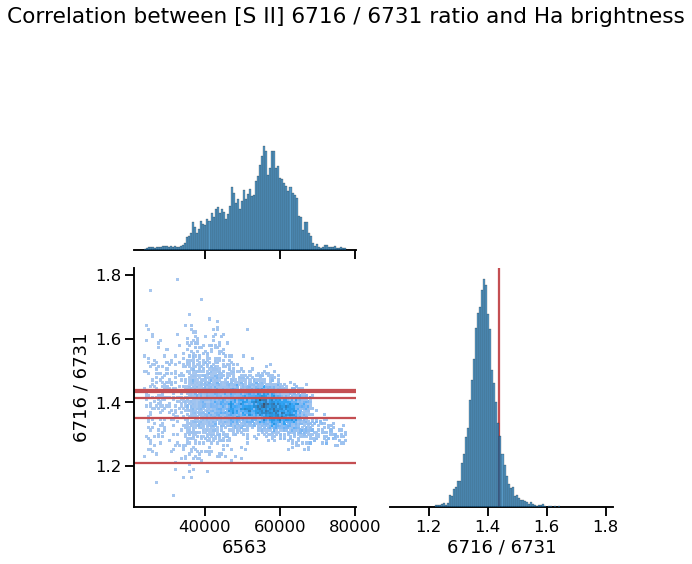

In [275]:
xslice, yslice = slice(230, 300), slice(144, 245)

n = 1

imx = imha[yslice, xslice].rebin(n)
imy = im6716[yslice, xslice].rebin(n) / im6731[yslice, xslice].rebin(n)

m = (imy.data > 1.1) & (imy.data < 2)
m = m & (imx.data < 80000)
m = m & ~imx.mask & ~imy.mask
df = pd.DataFrame(
    {
        "6563": imx.data[m],
        "6716 / 6731": imy.data[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=imx.data[m],
        bins=100,
    ),
    diag_kws=dict(
        weights=imx.data[m],
        bins=100,
    ),
)
g.axes[1, 1].axvline(Rgrid[0], color="r")
for R in Rgrid[:-1]:
    g.axes[1, 0].axhline(R, color="r")

g.fig.suptitle("Correlation between [S II] 6716 / 6731 ratio and Ha brightness");

So, in the bow shock region, we see ratios as low as 1.3 in the brightest parts, but these are globule surfaces.  The bulk of the emission has around 1.4

In [277]:
s2.getTemDen([1.4, 1.3, 0.8], tem=12000, wave1=6716, wave2=6731)

array([  45.20353656,  162.86088958, 1705.88138223])

So the density is about 50 +/- 30 pcc in the diffuse gas.  We get ten times higher density in the case of Source E, which has a ratio as low as 0.8

## He II emission measure

In [282]:
he2 = pn.RecAtom("He", 2)
he1 = pn.RecAtom("He", 1)
h1 = pn.RecAtom("H", 1)


In [296]:
e4686 = he2.getEmissivity(tem=18000, den=1, wave=4686)
e4686cold = he2.getEmissivity(tem=12000, den=1, wave=4686)
e4861 = h1.getEmissivity(tem=12000, den=1, wave=4861)
e5875 = he1.getEmissivity(tem=12000, den=1, wave=5876)
e4686, e4686cold, e4861, e5875

(array(8.172e-25),
 array(1.25516667e-24),
 array(1.05083333e-25),
 array(1.37667048e-25))

From the other notebook, we measure 5875 / 4861 = 0.108 +/- 0.001

Whereas the ratio of emissivities is 

In [290]:
e5875 / e4861

1.310075001033523

This implies a He abundance of 

In [295]:
np.array([0.107, 0.108, 0.109]) / (e5875 / e4861)

array([0.08167471, 0.08243803, 0.08320134])

From Table 5 of Valerdi+ (2019), they have a He+ abundance of 10.915 or 10.917, with error of +/- 0.004 , so:

In [294]:
10**(np.array([10.915, 10.917]) - 12.0)

array([0.08222426, 0.08260379])

They find a small He++ abundance of 

In [300]:
f"He++/H+ = {10**(8.30 - 12.0):.3e}; He++/He+ = {10**(8.30 - 10.915):.3e}"

'He++/H+ = 1.995e-04; He++/He+ = 2.427e-03; '

In the bow shock I measure 4686 / 4861 = 0.015 or so, which would be 1.5 on a scale of Hβ = 100.  Mabel's Table 2 gives 0.24, which is 6 times less. This is consistent with the general value we find away from the bow's inner edge. 

So, I can work out my own He++/H+ abundance: 

In [304]:
y_heiii_hii = 0.015 / (e4686 / e4861)
y_heiii_heii = y_heiii_hii / 0.08167471
f"Bow shock He++/H+ = {y_heiii_hii:.4f}; He++/He+ = {y_heiii_heii:.4f}"

'Bow shock He++/H+ = 0.0019; He++/He+ = 0.0236'

In other words, the He++ emission measure, $\int n(\mathrm{He^{++}})\, n_\mathrm{e}\, dz$, is ony 2.5% of the total $\int n(\mathrm{He^{+}})\, n_\mathrm{e}\, dz$.

*This is totally consistent, with the observed small change in 5875/4861, which is also about 2%* 

**TODO**

- [ ] By assuming a path length, we can derive a density
- [ ] We can do the same with [Ar IV] and [Ar III] 
- [ ] Ask Mabel to look at her slit A to see if she sees the He II and [Ar IV] signatures of the bow shock.  Also, maybe measure [O III] temperature to see if it goes up

## [Cl III] density

In [155]:
im5518 = Image("../data/ngc346-cliii-5518-bin01-sum.fits")
im5538 = Image("../data/ngc346-cliii-5538-bin01-sum.fits")
imha = Image("../data/ngc346-hi-6563-bin01-sum.fits")
imcont = Image("../data/ngc346-cont-4686-mean.fits")

In [156]:
cl3 = pn.Atom("Cl", 3)
Rlo = cl3.getLowDensRatio(wave1=5518, wave2=5538)
Rhi = cl3.getHighDensRatio(wave1=5518, wave2=5538)
Rlo, Rhi

(1.5, 0.213477825334669)

In [157]:
m = imcont.data > 3e2
im5518.mask = im5518.mask | m
im5538.mask = im5538.mask | m
trim_edges(im5518, 20)
trim_edges(im5538, 20)
trim_edges(imcont, 20)

In [158]:
shift5538 = 15.0 
shift5518 = 23.0
im5538.data += shift5538
im5518.data += shift5518

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


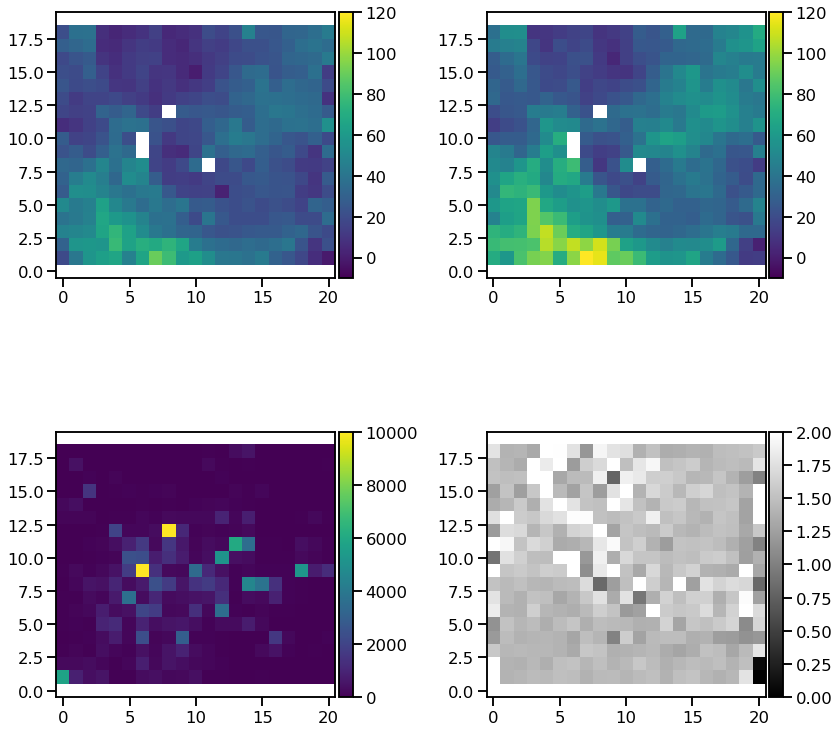

In [168]:
n = 16
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
im5538.rebin(n).plot(vmin=-10, vmax=120, ax=axes[0, 0], colorbar="v")
im5518.rebin(n).plot(vmin=-10, vmax=120, ax=axes[0, 1], colorbar="v")
imcont.rebin(n).plot(vmin=0, vmax=1e4, ax=axes[1, 0], colorbar="v")
(
    im5518.rebin(n)
    / im5538.rebin(n)
).plot(
    ax=axes[1, 1],
    vmin=0.0, 
    vmax=2.0, 
    cmap="gray", 
    colorbar="v",
)
fig.tight_layout();

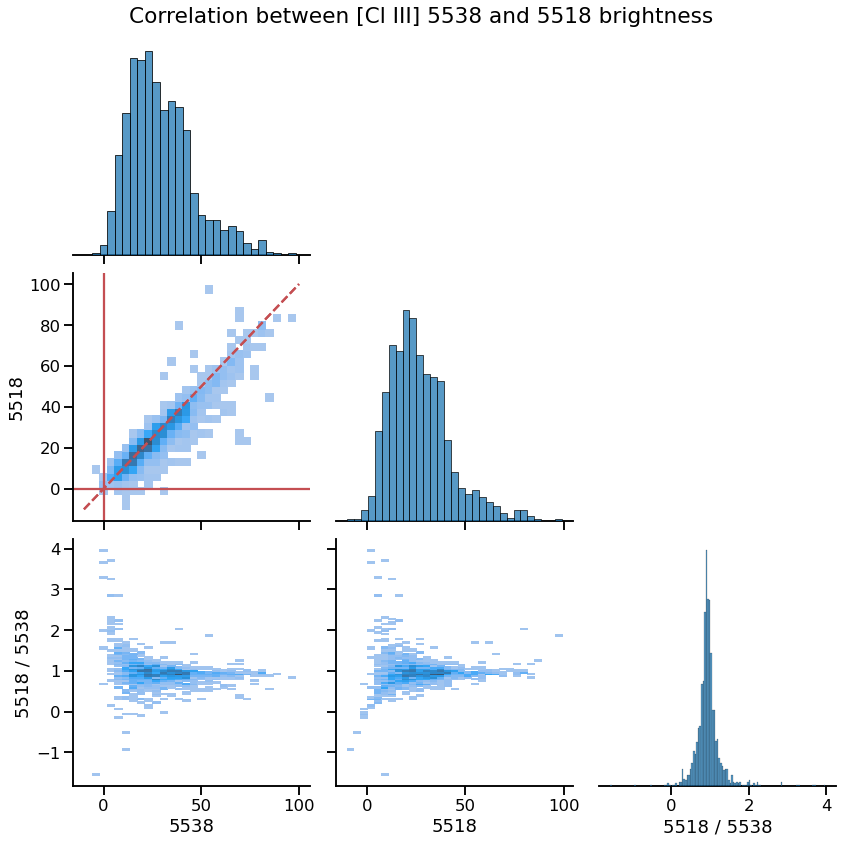

In [160]:
n = 8

imx = im5538.rebin(n)
imy = (im5518 /Rlo).rebin(n)

imin, imax = -10, 100
m = (imx.data < imax) & (imy.data < imax)
m = m & (imx.data > imin) & (imy.data > imin)
m = m & (imy.data / imx.data > -2) & (imy.data / imx.data  < 4.0)
m = m & ~imx.mask & ~imy.mask
df = pd.DataFrame(
    {
        "5538": imx.data[m],
        "5518": imy.data[m],
        "5518 / 5538": imy.data[m] / imx.data[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([imin, imax], [imin, imax], "--", color="r")
g.axes[1, 0].plot([imin, imax], [imin, imax], "--", color="r")
g.fig.suptitle("Correlation between [Cl III] 5538 and 5518 brightness");

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


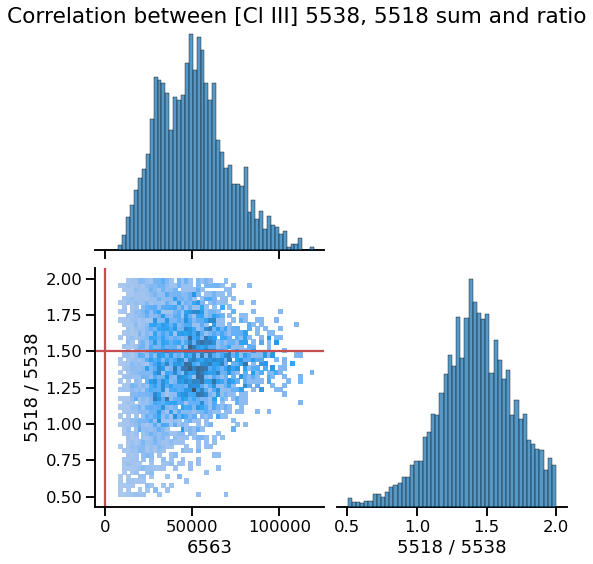

In [166]:
n = 4

imx = imha.rebin(n)
imy = im5518.rebin(n) / im5538.rebin(n)

imin, imax = -10, 100
m = (imy.data > 0.5) & (imy.data < 2.0)
m = m & (imx.data < 1.5e5)
m = m & ~imx.mask & ~imy.mask
df = pd.DataFrame(
    {
        "6563": imx.data[m],
        "5518 / 5538": imy.data[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=imx.data[m],
        bins=50,
    ),
    diag_kws=dict(
        weights=imx.data[m],
        bins=50,
    ),
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(1.5, color="r")
g.fig.suptitle("Correlation between [Cl III] 5538, 5518 sum and ratio");

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


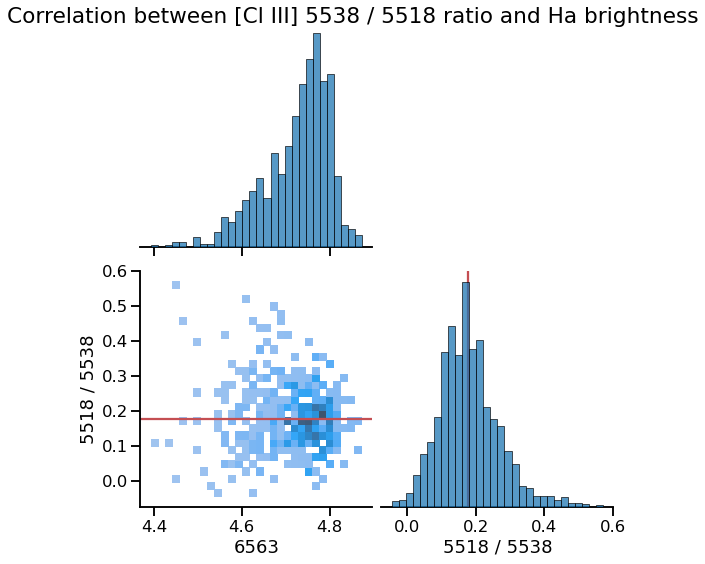

In [187]:
xslice, yslice = slice(230, 300), slice(144, 245)

n = 4

imx = imha[yslice, xslice].rebin(n)
imy = im5518[yslice, xslice].rebin(n) / im5538[yslice, xslice].rebin(n)

imin, imax = -10, 100
m = (imy.data > 0.15) & (imy.data < 15.0)
m = m & (imx.data < 1.5e5)
m = m & ~imx.mask & ~imy.mask
df = pd.DataFrame(
    {
        "6563": np.log10(imx.data[m]),
        "5518 / 5538": np.log10(imy.data[m]),
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=imx.data[m],
        bins=30,
    ),
    diag_kws=dict(
        weights=imx.data[m],
        bins=30,
    ),
)
g.axes[1, 0].axhline(np.log10(1.5), color="r")
g.axes[1, 1].axvline(np.log10(1.5), color="r")


g.fig.suptitle("Correlation between [Cl III] 5538 / 5518 ratio and Ha brightness");

In [211]:
m = ~im5518[yslice, xslice].mask
npix = m.sum()
y = im5518[yslice, xslice].data[m]
x = im5538[yslice, xslice].data[m]
w = imha[yslice, xslice].data[m]

# unweighted
ym = y.mean()
xm = x.mean()
R1 = ym / xm
dR1 = np.sqrt((y.var() / ym**2 + x.var() / xm**2) / (npix - 1))

# weighted 
ymw = np.average(y, weights=w)
xmw = np.average(x, weights=w)
R2 =  ymw / xmw
dR2 = np.sqrt(
    (
        np.average(((y - ymw) / ymw)**2, weights=w) 
        + np.average(((x - ymw) / xmw)**2, weights=w)
    ) / (npix - 1)
)
f"Unweighted R = {R1:.4f} +/- {dR1:.4f}; Weighted R = {R2:.4f} +/- {dR2:.4f}"

'Unweighted R = 1.4959 +/- 0.0090; Weighted R = 1.4924 +/- 0.0106'

In [219]:
cl3.getTemDen(1.44, tem=12000, wave1=5518, wave2=5538)

12.689610031679221

In [221]:
e5518 = cl3.getEmissivity(tem=12000, den=[1, 10, 100, 1000], wave=5518)
e5538 = cl3.getEmissivity(tem=12000, den=[1, 10, 100, 1000], wave=5538)
e5518 / e5538

array([1.44396914, 1.44119942, 1.41416716, 1.19711876])